In [1]:
#Import Packages
##Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from scipy.signal import find_peaks

In [2]:
#Get Data
cols = ["wavelength", "intensity"]
raw_data1 = pd.read_csv("DataFiles/Devins_Phone_slit_Smaller_300_900_nm_run_multi_1.txt", delimiter="\t", names=cols)
raw_data2 = pd.read_csv("DataFiles/Refresh_Bulb_slit_Smaller_300_900_nm_run_multi_3.txt", delimiter="\t", names=cols)




np.max(raw_data1["intensity"])
np.max(intensity)

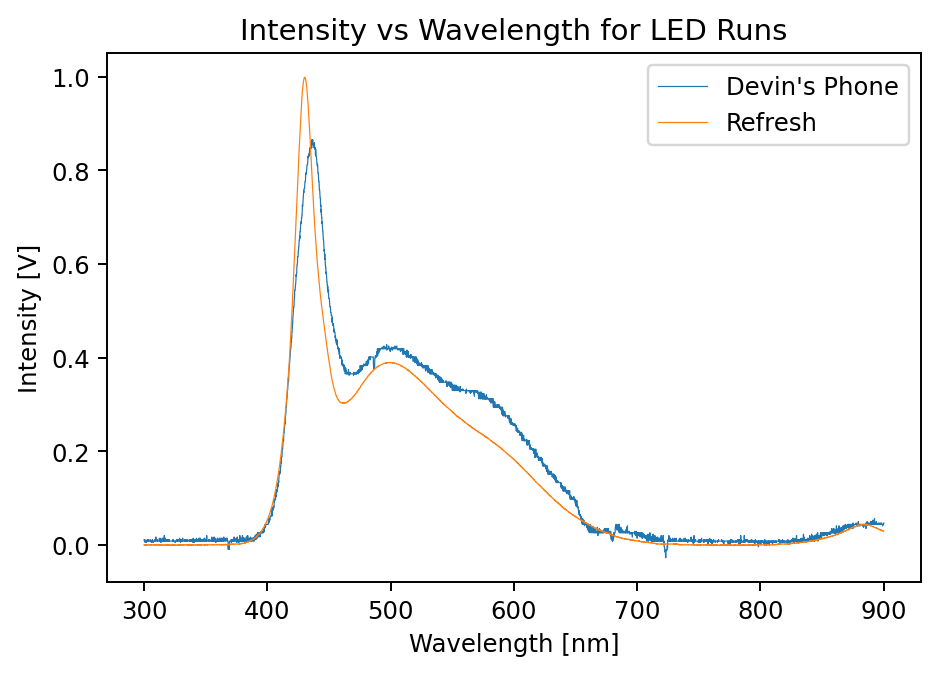

In [3]:
plt.figure(dpi=175)
plt.title("Intensity vs Wavelength for LED Runs")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Intensity [V]")


plt.plot(raw_data1["wavelength"], (raw_data1["intensity"]-0.0355+0*np.min(raw_data1["intensity"]))/np.max(raw_data1["intensity"]), lw=.5, label="Devin's Phone")
plt.plot(raw_data2["wavelength"], (raw_data2["intensity"]-0.0037)/np.max(raw_data2["intensity"]), lw=.5, label="Refresh")

#plt.ylim(0,.05)

plt.legend()

plt.savefig("Plots/LED_Comparison.pdf")

### LED Fitting

[1.83622473e-01 4.34320891e+02 1.25199659e+01 9.70293767e-02
 4.88635604e+02 3.81509425e+01 7.42124266e-02 5.77216143e+02
 4.46350781e+01 3.74800420e-02]
[4.12630771e-04 1.81120162e-02 2.84522478e-02 5.11293133e-04
 2.76366092e-01 2.49732888e-01 3.84781458e-04 4.93463075e-01
 2.75872527e-01 6.75193284e-05]
[0.22471692 0.00417019 0.22725499 0.52694674 0.05655873 0.65459166
 0.51848656 0.08549017 0.61806216 0.18014742]


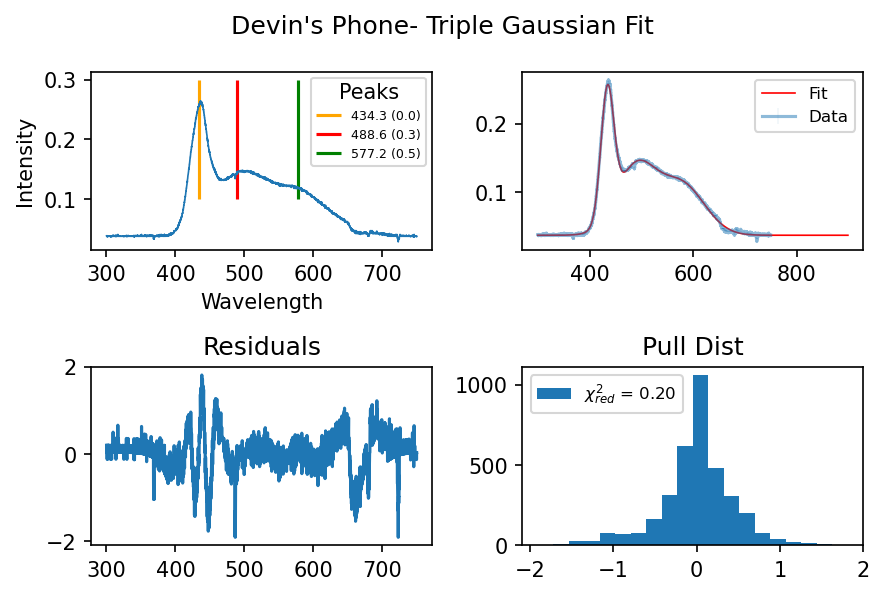

CPU times: user 1.1 s, sys: 89.4 ms, total: 1.19 s
Wall time: 1.21 s


In [7]:
%%time
def gauss(x,mu=0,sigma=1):
    return np.exp(-((mu-x)**2/(2*(sigma)**2)))

def triple_Gauss(x, A,mu1,sig1, B,mu2,sig2, C,mu3,sig3, d): 
    return A*gauss(x,mu1,sig1) + B*gauss(x,mu2,sig2) + C*gauss(x,mu3,sig3) + d

##Get Hist
plt.figure(dpi=150)
plt.suptitle(f"Devin's Phone- Triple Gaussian Fit")
plt.subplot(2, 2, 1)
plt.xlabel("Wavelength")
plt.ylabel("Intensity")

keeps = raw_data1["wavelength"] < 750

wavelength = raw_data1["wavelength"][keeps]
intensity = raw_data1["intensity"][keeps]

plt.plot(wavelength, intensity, lw=.8)

errors = intensity.values*0 + .005

pars, cov = scipy.optimize.curve_fit(triple_Gauss, wavelength.values, intensity.values, #maxfev=3*10**5, sigma=errors,
                                     p0=[1,420,50, 1,500,50, 1,580,50, .2],
                                     bounds=([0.01,400,1, 0.01,480,1, 0.01,100,1, 0],
                                             [5,480,200, 5,700,520, 5,700,200, .5]))
#Mean Lines
plt.vlines(pars[1],0.1,0.3, label=f"{pars[1]:.1f} ({np.sqrt(cov.diagonal())[1]:.1f})", color="orange")
plt.vlines(pars[4],0.1,0.3, label=f"{pars[4]:.1f} ({np.sqrt(cov.diagonal())[4]:.1f})", color="red")
plt.vlines(pars[7],0.1,0.3, label=f"{pars[7]:.1f} ({np.sqrt(cov.diagonal())[7]:.1f})", color="green")

plt.legend(title="Peaks", prop={"size":6})

#Plot Fit
plt.subplot(2, 2, 2)
x = np.arange(300,900,1)
#shows = (np.arange(0,len(wavelength),1)%10 == 0)

plt.errorbar(wavelength.values, 
             intensity.values, yerr=errors/10, ms=.2, elinewidth=.1, alpha=0.5, label="Data")
plt.plot(x, triple_Gauss(x, *pars), color="red", lw=.8, label="Fit")
plt.legend(prop={"size":8})
#plt.set_xticks(np.arange(300,901,50), minor=1)

print(pars)
print(np.sqrt(cov.diagonal()))
print(np.sqrt(cov.diagonal())/np.abs(pars)*100)

#Residuals
residuals = (intensity.values-triple_Gauss(wavelength.values, *pars))/errors
plt.subplot(2, 2, 3)
plt.title("Residuals")
plt.plot(wavelength.values, residuals)#, s=1)

#Pull Dist
plt.subplot(2, 2, 4)
plt.title("Pull Dist")
red = "{red}"
plt.hist(residuals, 20, label=f"$\chi_{red}^2$ = {np.sum(residuals**2)/len(residuals):.2f}")
plt.legend(prop={"size":8})

plt.tight_layout()
plt.savefig(f"Plots/DevinPhone_Fit.pdf")
plt.show()